In [67]:
import pandas as pd
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [68]:
data = pd.read_csv('data/bitcoin_USD_close_data-2017-02-09_2018-02-09.csv',
                   parse_dates=['Date'])
print(data.shape)
data.tail()

(366, 2)


,Date,Price
361,2018-02-05,6914.26
362,2018-02-06,7700.39
363,2018-02-07,7581.80
364,2018-02-08,8237.24
365,2018-02-09,8689.84


In [69]:
data['Date'] = data['Date'].dt.date
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop('Date', axis=1, inplace=True)
data.head()

,Price
Date,
2017-02-09,988.95
2017-02-10,993.08
2017-02-11,1010.00
2017-02-12,999.51
2017-02-13,996.86


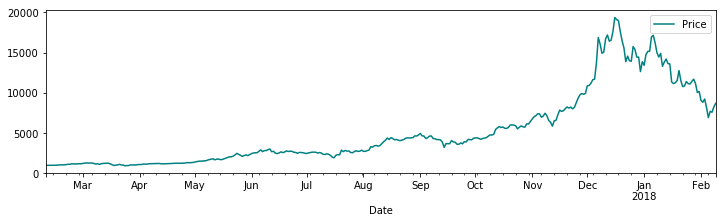

In [70]:
data.plot(y='Price', color='teal', figsize=(12,3))

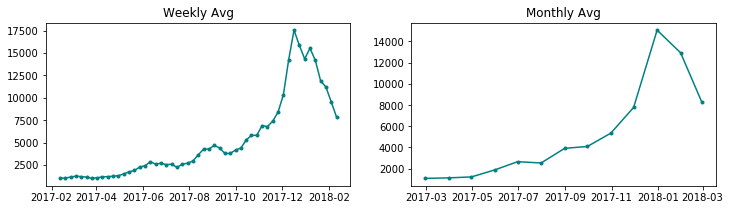

In [55]:
price_weekly_avg = data.resample('W').apply(np.mean)
price_monthly_avg = data.resample('M').apply(np.mean)
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.Price, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.Price, "-o", markersize=3, color='teal')

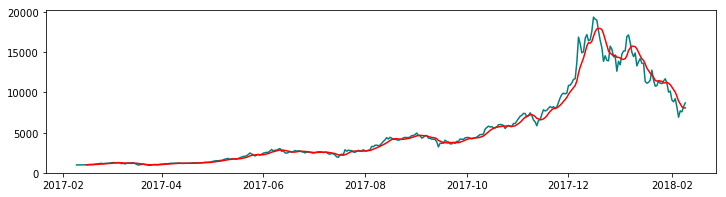

In [71]:
rolling_mean = data.Price.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
plt.figure(figsize=(12,3))
plt.plot(data.Price, color='teal')
plt.plot(rolling_mean, 'red') 

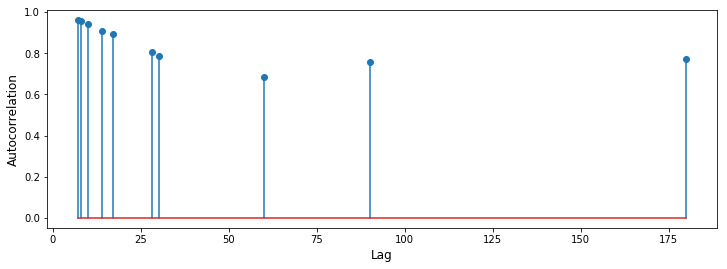

In [72]:
lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [data.Price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

The greatest correlations seems to be rpoduced from lag of 7, meaning our data has weekly seasonality. You can see that from below graph too where the highest correlation value is roughly upto the lag of 10.

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


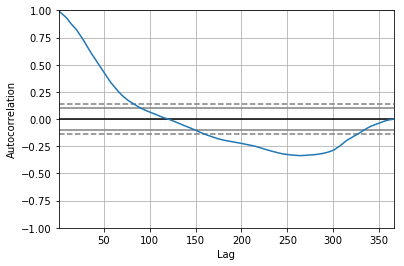

In [58]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(data) 

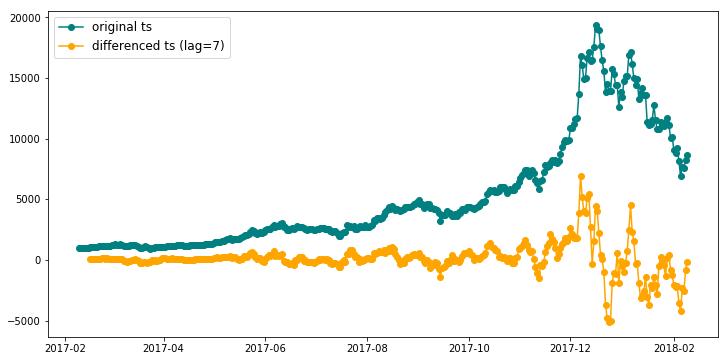

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(data.Price, '-o', color='teal', label="original ts")
plt.plot(data.Price.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)


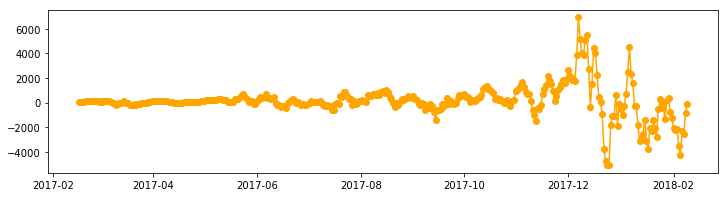

In [81]:
prices = data.Price
price_diff = prices.diff(7).dropna() 

plt.figure(figsize=(12,3))
plt.plot(price_diff, "-o", color='orange')

Above figure seems stationary enough so optlag=7 chosen for following operations

In [82]:
time_series = price_diff #time series with diff of 7 as from autocorrelation 7 seems to be the best one (data very correlated 
# every 7 days)

#### Now lets try with SKLearn linearRegression and then AR and ARMA models (time_series has not changed still diff =7)

For linear regression on time series we need to organize the data with matrix X where each row contains a forecast windiw and y is the target values for each row of X.

In [83]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 90
X, y = organize_data(time_series, lag)

MAE = 241.978
MAE2 = 335.892


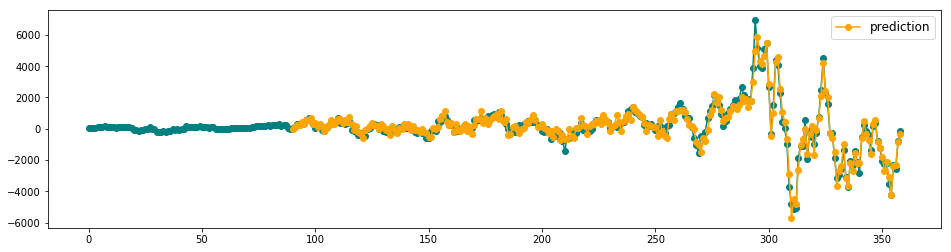

In [84]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

plt.figure(figsize=(16, 4))
plt.plot(time_series.values, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], lr_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], lr_prediction[-90:]))) #for the last 90 days only

**Auto-Regressive model (AR)**

In [51]:
ar = tsa.AR(time_series)
optlag = ar.select_order(91, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag))

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:612: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1712: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best optimal lag for ar model: 47


MAE = 241.913
MAE2 = 335.497


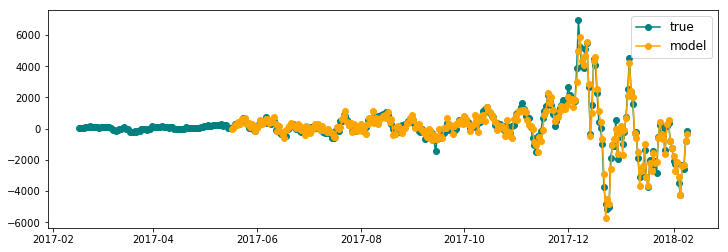

In [85]:
lag = 90 #90 gives lower error though might be useful experimenting with that too
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag, ic='aic')
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(12, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], ar_prediction[-90:]))) #error only for the last 90 days


**Auto-Regressive Moving Average (ARMA) model**

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAE = 319.051
MAE2 = 647.323


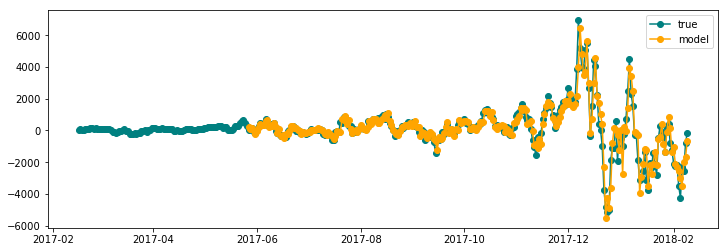

In [86]:
arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
start=100
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(12, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], arma_prediction[-90:]))) #error only for the last 90 days


### Now out of sample forcasting (the next 7 days)

In [87]:
train = time_series[:-7]
test = time_series[-7:]

In [88]:
#7 out of sample prediction with AR 
lag = 47
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+6)[-len(test):] 
ar_forecast

2018-02-10    -654.683766
2018-02-11    -116.566214
2018-02-12    1158.861627
2018-02-13    1209.549713
2018-02-14    2028.570897
2018-02-15    1947.398843
2018-02-16    2259.390295
Freq: D, dtype: float64

In [89]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(7, 7)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+6)[-len(test):]
arma_forecast

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2018-02-10    -465.836826
2018-02-11     899.485866
2018-02-12    1557.258388
2018-02-13     882.516934
2018-02-14    1192.692812
2018-02-15     109.410093
2018-02-16     187.347293
Freq: D, dtype: float64

In [90]:
#and here ARIMA which basically gives same thing as ARMA but in a different way. 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=7)[0]
arima_forecast

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


array([ -465.83682587,   899.48586553,  1557.25838799,   882.5169341 ,
        1192.69281217,   109.41009282,   187.34729317])

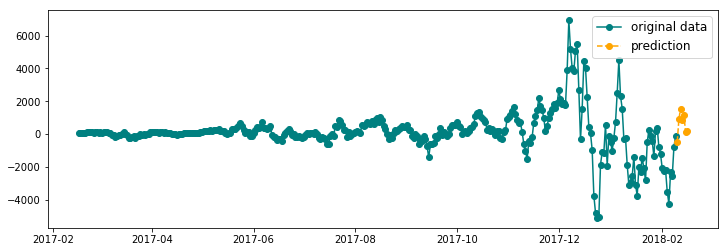

In [91]:
plt.figure(figsize=(12, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

### Now we need to find the actual next 7 out of sample values by adding each predicted diff value to the actual price 7 days before them 

In [92]:
print(prices[-7:]) #the actual last 7 sample prices

Date
2018-02-03    9224.39
2018-02-04    8186.65
2018-02-05    6914.26
2018-02-06    7700.39
2018-02-07    7581.80
2018-02-08    8237.24
2018-02-09    8689.84
Name: Price, dtype: float64


In [93]:
idx = arma_forecast.index.values

forecast_prices = []
lag = 7
for i, diff in enumerate(arma_forecast): #choosing ARMA as it produced lower MAE than AR model
    prev_value = prices[-(lag)+i:][0]
    forecast_prices.append(prev_value+diff)
    
bitcoin_forecast = pd.Series(forecast_prices, index=idx)
bitcoin_forecast

2018-02-10    8758.553174
2018-02-11    9086.135866
2018-02-12    8471.518388
2018-02-13    8582.906934
2018-02-14    8774.492812
2018-02-15    8346.650093
2018-02-16    8877.187293
dtype: float64

<function matplotlib.pyplot.show>

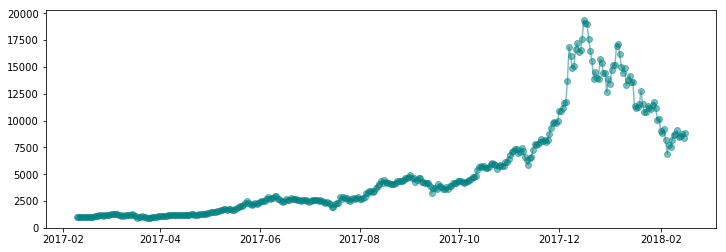

In [94]:
hist_values = data['Price'].append(bitcoin_forecast)

plt.figure(figsize=(12,4))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show